# rho-Simulated SBM, n=150,1500

In [1]:
#hide
%load_ext autoreload
%autoreload 1


In [2]:
from pkg.gmp import quadratic_assignment
from pkg.gmp import quadratic_assignment_ot
from pkg.plot import set_theme
import numpy as np

In [3]:

import sys
sys.path
sys.path.insert(0,'../../graspologic')

# Experiment Summary, n = 150
Let $(G_1, G_2) \sim \rho-SBM(\vec{n},B)$. (NB: binary, symmetric, hollow.)

$K = 3$.

the marginal SBM is conditional on block sizes $\vec{n}=[n_1,n_2,n_3]$.

$B = [(.20,.01,.01);(.01,.10,.01);(.01,.01,.20)]$. (NB: rank($B$)=3 with evalues $\approx [0.212,0.190,0.098]$.)

with $n = 150$ and $\vec{n}=[n_1,n_2,n_3] = [50,50,50]$

for each $\rho \in \{0.5,0.6,\ldots,0.9,1.0\}$ generate $r$ replicates $(G_1, G_2)$.

For all $r$ replicates, run $GM$ and $GM_{LS}$ (where $GM_{LS}$ uses the "Lightspeed sinkhorn distances" for computing the step direction) each $t$ times, with each $t$ corresponding to a different random permutation on $G_2$ . 

Specifically,$G_2' = Q G_2 Q^T,$ where $Q$ is sampled uniformly from the set of $n x n$ permutations matrices.

For each $t$ permutation, run $GM$ & $GM_{LS}$ from the barycenter ($\gamma = 0$).

For each $r$, the $t$ permutation with the highest associated objective function value will have it's match ratio recorded

For any $\rho$ value, have $\delta$ denote the average match ratio over the $r$ realizations

Plot $x=\rho$ vs $y$= $\delta$ $\pm$ 2s.e.

Below contains figures for $r=50$, $t=10$ 



In [30]:
#hide
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from joblib import Parallel, delayed
import seaborn as sns
# from graspy.match import GraphMatch as GMP
from graspologic.simulations import sbm_corr
# from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

r = 100
t=10
# gmp = GraphMatch('maximize':True, 'tol':0.000001,'maxiter':30, 'shuffle_input':True)
def match_ratio(inds, n):
    return np.count_nonzero(inds == np.arange(n)) / n

        
n = 150
m = r
rhos = 0.1 * np.arange(11)[5:]
# rhos = np.arange(8,10.5,0.5) *0.1
n_p = len(rhos)

ratios = np.zeros((n_p,m))
scores = np.zeros((n_p,m))

ratios_ss = np.zeros((n_p,m))
scores_ss = np.zeros((n_p,m))


n_per_block = int(n/3)
n_blocks = 3
block_members = np.array(n_blocks * [n_per_block])
block_probs = np.array([[0.2, 0.01, 0.01], [0.01, 0.1, 0.01], [0.01, 0.01, 0.2]])
directed = False
loops = False
for k, rho in enumerate(rhos):
    np.random.seed(8888)
    seeds = [np.random.randint(1e8, size=t) for i in range(m)]
    def run_sim(seed):
        
        A1, A2 = sbm_corr(
            block_members, block_probs, rho, directed=directed, loops=loops
        )
        score = 0
        res_opt = None

        score_ss = 0
        res_opt_ss = None

        for j in range(t):
            res = quadratic_assignment(A1,A2, options={'maximize':True,'tol':1e-6,'maxiter':50, 'shuffle_input':True})
            if res.fun>score:
                perm = res.col_ind
                score = res.fun

            res_ss = quadratic_assignment_ot(A1,A2, options={'maximize':True,'tol':1e-6,'maxiter':50, 'shuffle_input':True, 'reg': 100, 'thr':1e-2})
            if res_ss.fun>score_ss:
                perm_ss = res_ss.col_ind
                score_ss = res_ss.fun
                
        ratio = match_ratio(perm, n)

        ratio_ss = match_ratio(perm_ss, n)

        return ratio, score, ratio_ss, score_ss

    result = Parallel(n_jobs=-1)(delayed(run_sim)(seed) for seed in seeds)

    ratios[k,:] = [item[0] for item in result]
    scores[k,:] = [item[1] for item in result]
    ratios_ss[k,:] = [item[2] for item in result]
    scores_ss[k,:] = [item[3] for item in result]

## Caption:
Average match ratio $\pm$ 2 s.e. as a function of correlation values $\rho$ in $\rho$-SBM simulations on $n=150, 1500$ nodes.

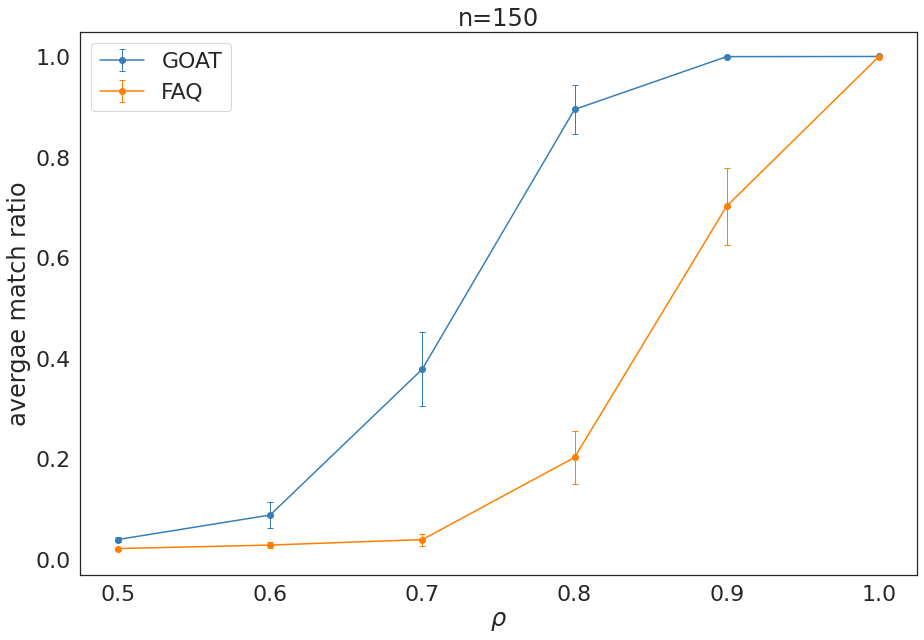

In [31]:
#collapse
from scipy.stats import sem
cb = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
error = [2*sem(ratios[i,:]) for i in range(n_p)]
average = [np.mean(ratios[i,:] ) for i in range(n_p)]

error_ss = [2*sem(ratios_ss[i,:]) for i in range(n_p)]
average_ss = [np.mean(ratios_ss[i,:] ) for i in range(n_p)]

sns.set_context('poster')
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale = 2)
sns.set_style('white')

# plt.set_cmap(CB_color_cycle)

sns.set_palette(sns.color_palette('colorblind'))
plt.errorbar(rhos,average_ss, error_ss,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GOAT', color=cb[0])
plt.errorbar(rhos,average, error,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='FAQ', color=cb[1])
plt.xlabel(r"$\rho$")
plt.ylabel("avergae match ratio")

plt.title('n=150')
plt.legend()

# Experiment Summary, n = 1500
Let $(G_1, G_2) \sim \rho-SBM(\vec{n},B)$. (NB: binary, symmetric, hollow.)

$K = 3$.

the marginal SBM is conditional on block sizes $\vec{n}=[n_1,n_2,n_3]$.

$B = [(.20,.01,.01);(.01,.10,.01);(.01,.01,.20)]$. (NB: rank($B$)=3 with evalues $\approx [0.212,0.190,0.098]$.)

with $n = 150$ and $\vec{n}=[n_1,n_2,n_3] = [50,50,50]$

for each $\rho \in \{0.8, 0.85, 0.9, 0.95, 1.0\}$ generate $r$ replicates $(G_1, G_2)$.

For all $r$ replicates, run $GM$ and $GM_{LS}$ (where $GM_{LS}$ uses the "Lightspeed sinkhorn distances" for computing the step direction) each $t$ times, with each $t$ corresponding to a different random permutation on $G_2$ . 

Specifically,$G_2' = Q G_2 Q^T,$ where $Q$ is sampled uniformly from the set of $n x n$ permutations matrices.

For each $t$ permutation, run $GM$ & $GM_{SS}$ from the barycenter ($\gamma = 0$).

For each $r$, the $t$ permutation with the highest associated objective function value will have it's match ratio recorded

For any $\rho$ value, have $\delta$ denote the average match ratio over the $r$ realizations

Plot $x=\rho$ vs $y$= $\delta$ $\pm$ s.e.

Below contains figures for $r=25$, $t=5$ 

In [44]:
#hide
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from joblib import Parallel, delayed
import seaborn as sns
# from graspy.match import GraphMatch as GMP
from graspologic.simulations import sbm_corr
# from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

r = 25
t=5
# gmp = GraphMatch('maximize':True, 'tol':0.000001,'maxiter':30, 'shuffle_input':True)
def match_ratio(inds, n):
    return np.count_nonzero(inds == np.arange(n)) / n

        
n = 1500
m = r
rhos = 0.1 * np.arange(11)[5:]
# rhos = np.arange(8,10.5,0.5) *0.1
n_p = len(rhos)

ratios = np.zeros((n_p,m))
scores = np.zeros((n_p,m))

ratios_ss = np.zeros((n_p,m))
scores_ss = np.zeros((n_p,m))


n_per_block = int(n/3)
n_blocks = 3
block_members = np.array(n_blocks * [n_per_block])
block_probs = np.array([[0.2, 0.01, 0.01], [0.01, 0.1, 0.01], [0.01, 0.01, 0.2]])
directed = False
loops = False
for k, rho in enumerate(rhos):
    np.random.seed(8888)
    seeds = [np.random.randint(1e8, size=t) for i in range(m)]
    def run_sim(seed):
        
        A1, A2 = sbm_corr(
            block_members, block_probs, rho, directed=directed, loops=loops
        )
        score = 0
        res_opt = None

        score_ss = 0
        res_opt_ss = None

        for j in range(t):
            res = quadratic_assignment(A1,A2, options={'maximize':True, 'tol':1e-3,'maxiter':30, 'shuffle_input':True})
            if res.fun>score:
                perm = res.col_ind
                score = res.fun

            res_ss = quadratic_assignment_ot(A1,A2, options={'maximize':True, 'tol':1e-3,'maxiter':30, 'shuffle_input':True, 'reg': 100})
            if res_ss.fun>score_ss:
                perm_ss = res_ss.col_ind
                score_ss = res_ss.fun
                
        ratio = match_ratio(perm, n)

        ratio_ss = match_ratio(perm_ss, n)

        return ratio, score, ratio_ss, score_ss

    result = Parallel(n_jobs=-1)(delayed(run_sim)(seed) for seed in seeds)

    ratios[k,:] = [item[0] for item in result]
    scores[k,:] = [item[1] for item in result]
    ratios_ss[k,:] = [item[2] for item in result]
    scores_ss[k,:] = [item[3] for item in result]

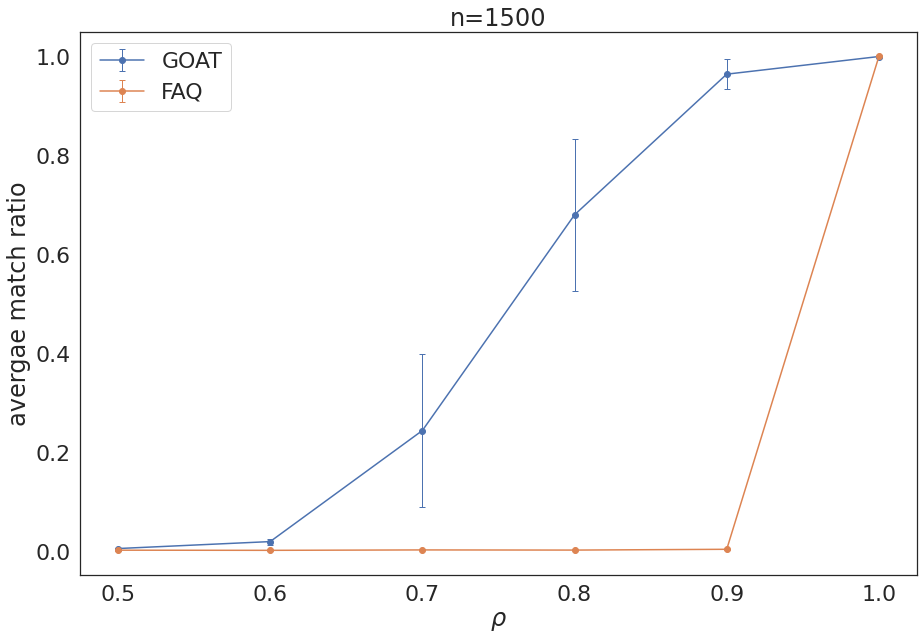

In [45]:

from scipy.stats import sem
error1500 = [2*sem(ratios[i,:]) for i in range(n_p)]
average1500 = [np.mean(ratios[i,:] ) for i in range(n_p)]

error_ss1500 = [2*sem(ratios_ss[i,:]) for i in range(n_p)]
average_ss1500 = [np.mean(ratios_ss[i,:] ) for i in range(n_p)]

sns.set_context('poster')
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale = 2)
sns.set_style('white')

plt.errorbar(rhos,average_ss1500, error_ss1500,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GOAT')
plt.errorbar(rhos,average1500, error1500,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='FAQ')
plt.xlabel(r"$\rho$")
plt.ylabel("avergae match ratio")

plt.title('n=1500')
plt.legend()

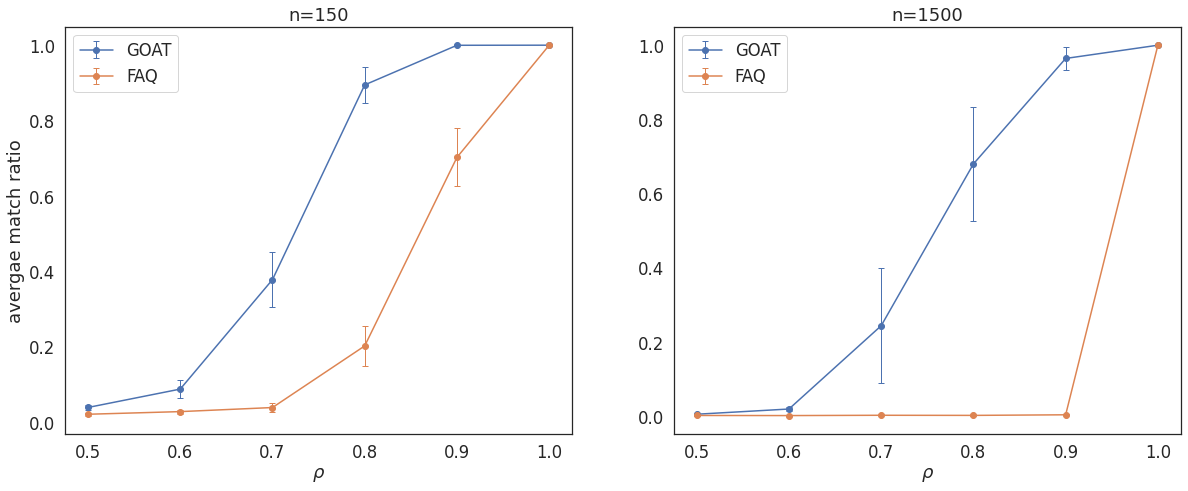

In [46]:
sns.set(font_scale = 1.5)
sns.set_style('white')
fig, axes = plt.subplots(1, 2, figsize=(20, 7.5))
rhos1 = 0.1 * np.arange(11)[5:]
axes[0].errorbar(rhos1,average_ss, error_ss,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GOAT')
axes[0].errorbar(rhos1,average, error,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='FAQ')
axes[0].set_xlabel(r"$\rho$")
axes[0].set_ylabel("avergae match ratio")

axes[0].set_title('n=150')
axes[0].legend()
axes[1].errorbar(rhos,average_ss1500, error_ss1500,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GOAT')
axes[1].errorbar(rhos,average1500, error1500,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='FAQ')
axes[1].set_xlabel(r"$\rho$")
# plt.ylabel("avergae match ratio")

axes[1].set_title('n=1500')
axes[1].legend()
plt.savefig('sgm.png')
# axes[0].set_ylabel("average match ratio")
# for i in range(3):
#     sns.set(font_scale = 2)
#     sns.set_style('white')
#     axes[i].errorbar(m,ratios[:, i], 2*error[:, i], fmt='.-',capsize=3, elinewidth=1, markeredgewidth=1, label='GOAT')
#     axes[i].errorbar(m,ratios2[:, i], 2*error2[:, i],fmt='.-',capsize=3, elinewidth=1, markeredgewidth=1, label='FAQ')
#     axes[i].legend(prop={'size': 15})
#     axes[i].set_title(fr'$\rho$ = {np.around(rhos[i],2)}', fontsize=15)
#     axes[i].set_xlabel("number of seeds (m)")
    
plt.savefig('rho_sbm.png')



# GOAT for different values of reg = [100, 200, 300, 500, 700]

In [26]:
#hide
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from joblib import Parallel, delayed
import seaborn as sns
# from graspy.match import GraphMatch as GMP
from graspologic.simulations import sbm_corr
# from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

r = 50
t=10
# gmp = GraphMatch('maximize':True, 'tol':0.000001,'maxiter':30, 'shuffle_input':True)
def match_ratio(inds, n):
    return np.count_nonzero(inds == np.arange(n)) / n

        
n = 150
m = r
rhos = 0.1 * np.arange(11)[5:]
# rhos = np.arange(8,10.5,0.5) *0.1
n_p = len(rhos)

ratios_1 = np.zeros((n_p,m))

ratios_2 = np.zeros((n_p,m))
ratios_3 = np.zeros((n_p,m))
ratios_5 = np.zeros((n_p,m))
ratios_7 = np.zeros((n_p,m))

n_per_block = int(n/3)
n_blocks = 3
block_members = np.array(n_blocks * [n_per_block])
block_probs = np.array([[0.2, 0.01, 0.01], [0.01, 0.1, 0.01], [0.01, 0.01, 0.2]])
directed = False
loops = False
for k, rho in enumerate(rhos):
    np.random.seed(8888)
    seeds = [np.random.randint(1e8, size=t) for i in range(m)]
    def run_sim(seed):
        
        A1, A2 = sbm_corr(
            block_members, block_probs, rho, directed=directed, loops=loops
        )
        score_1 = 0
        score_2 = 0
        score_3 = 0
        score_5 = 0
        score_7 = 0

#         res_1 = None
#         res_2 = None
#         res_3 = None
#         res_4 = None
#         res_5 = None
        def run_qap(reg):
            score = 0
            for j in range(t):
                res = quadratic_assignment_ot(A1,A2, options={'maximize':True,'tol':1e-6,'maxiter':50, 'shuffle_input':True, 'reg': reg, 'thr':1e-2})
                if res.fun>score:
                    perm = res.col_ind
                    score = res.fun
            return perm
                
        ratio_1 = match_ratio(run_qap(100), n)
        ratio_2 = match_ratio(run_qap(200), n)
        ratio_3 = match_ratio(run_qap(300), n)
        ratio_5 = match_ratio(run_qap(500), n)
        ratio_7 = match_ratio(run_qap(700), n)

        return ratio_1, ratio_2, ratio_3, ratio_5, ratio_7

    result = Parallel(n_jobs=-1)(delayed(run_sim)(seed) for seed in seeds)

    ratios_1[k,:] = [item[0] for item in result]
    ratios_2[k,:] = [item[1] for item in result]
    ratios_3[k,:] = [item[2] for item in result]
    ratios_5[k,:] = [item[3] for item in result]
    ratios_7[k,:] = [item[4] for item in result]

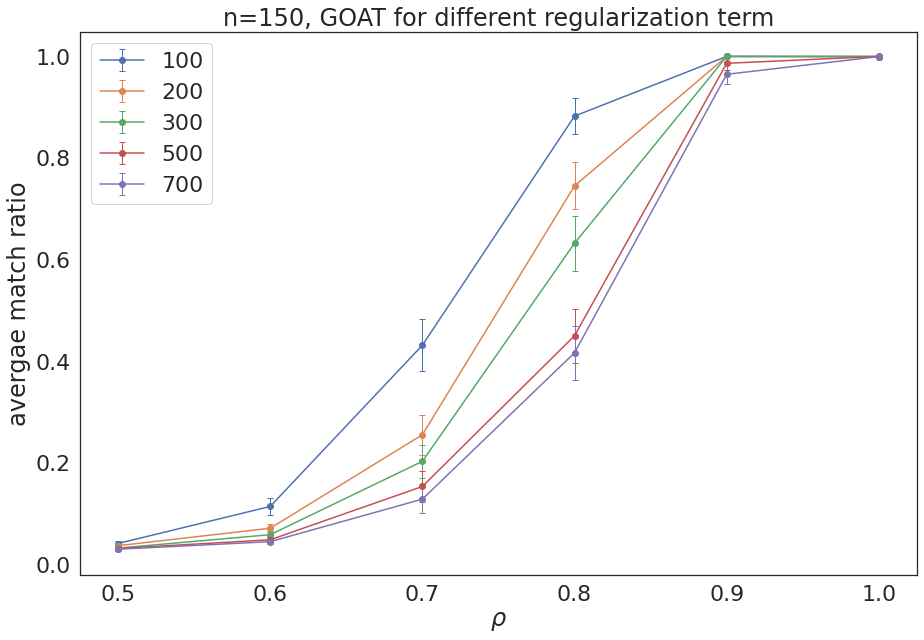

In [38]:
from scipy.stats import sem
error_1 = sem(ratios_1, axis=1)
average_1 = np.mean(ratios_1, axis=1)

error_2 = sem(ratios_2, axis=1)
average_2 = np.mean(ratios_2, axis=1)

error_3 = sem(ratios_3, axis=1)
average_3 = np.mean(ratios_3, axis=1)

error_5 = sem(ratios_5, axis=1)
average_5 = np.mean(ratios_5, axis=1)

error_7 = sem(ratios_7, axis=1)
average_7 = np.mean(ratios_7, axis=1)

#sns.set_context('poster')
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale = 2)
sns.set_style('white')

# txt =f'r={r}, t={t}'
plt.errorbar(rhos,average_1, error_1,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='100')
plt.errorbar(rhos,average_2, error_2,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='200')
plt.errorbar(rhos,average_3, error_3,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='300')
plt.errorbar(rhos,average_5, error_5,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='500')
plt.errorbar(rhos,average_7, error_7,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='700')
sns.color_palette('bright')
plt.xlabel(r"$\rho$")
plt.ylabel("avergae match ratio")
# plt.text(0.5,0.5,txt)
plt.title('n=150, GOAT for different regularization term')
plt.legend()